# Project \#3: Boston housing
by Polina Guseva 

In [1]:
# first of all, let's import all necessary libraries

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# linear models
import statsmodels.api as sm
import statsmodels.formula.api as smf

# statistical tests
import scipy.stats as stats

# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 1: building a linear model

### raw data

In [2]:
# upload our dataset
! gdown 1HCJG0YAJUmMVUePkU2KnxJNRmIIWAOre

Downloading...
From: https://drive.google.com/uc?id=1HCJG0YAJUmMVUePkU2KnxJNRmIIWAOre
To: /content/BostonHousing.csv
100% 35.7k/35.7k [00:00<00:00, 30.1MB/s]


In [3]:
# let's have a look
df = pd.read_csv('/content/BostonHousing.csv')
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Data description (from [Kaggle](https://www.kaggle.com/c/boston-housing))

The Boston data frame has 506 rows and 14 columns.

This data frame contains the following columns:

* **crim**: per capita crime rate by town.
* **zn**: proportion of residential land zoned for lots over 25,000 sq.ft.
* **indus**: proportion of non-retail business acres per town.
* **chas**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
* **nox**: nitrogen oxides concentration (parts per 10 million).
* **rm**: average number of rooms per dwelling.
* **age**: proportion of owner-occupied units built prior to 1940.
* **dis**: weighted mean of distances to five Boston employment centres.
* **rad**: index of accessibility to radial highways.
* **tax**: full-value property-tax rate per \$10,000.
* **ptratio**: pupil-teacher ratio by town.
* **b** (or black): 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
* **lstat**: lower status of the population (percent).
* **medv**: median value of owner-occupied homes in \$1000s.

Text(0.5, 1.0, 'Correlation between all categories in the dataframe')

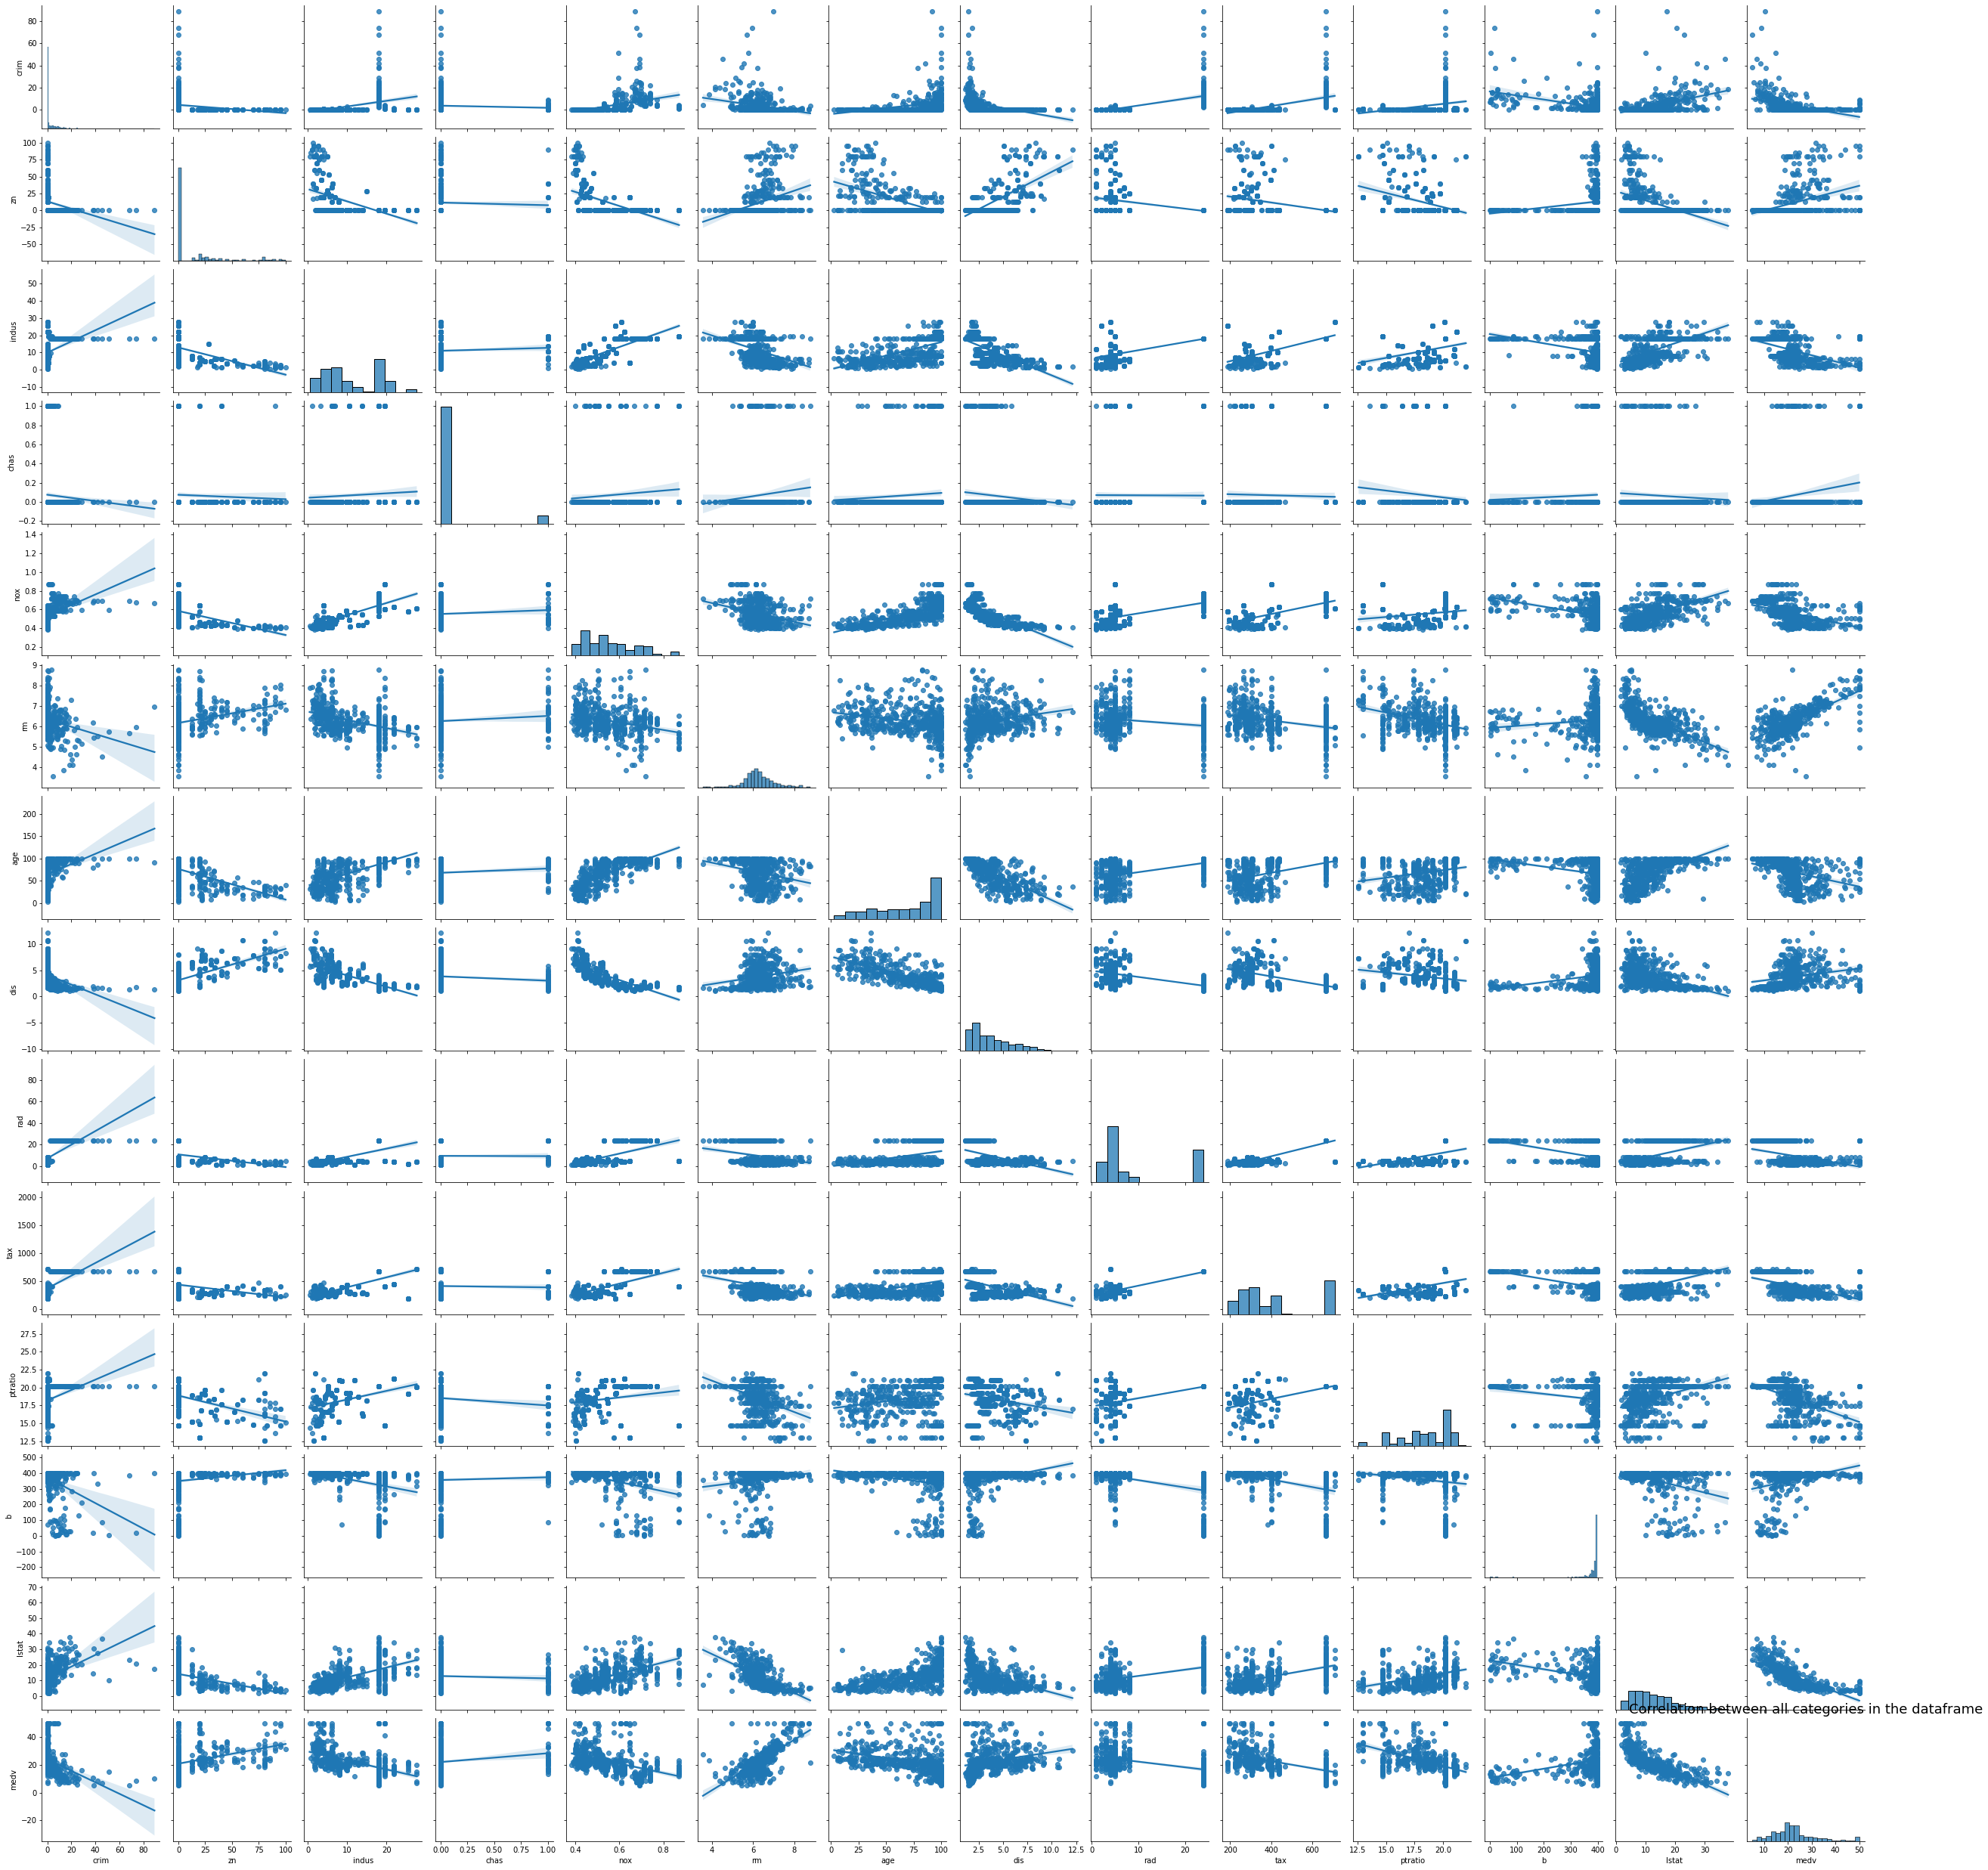

In [4]:
# let's have a look at every possible correlations
sns.pairplot(df, kind='reg')
plt.title('Correlation between all categories in the dataframe', 
          fontsize=18)

Text(0.5, 0.98, 'Hierarchical correlation between all categories in the dataframe')

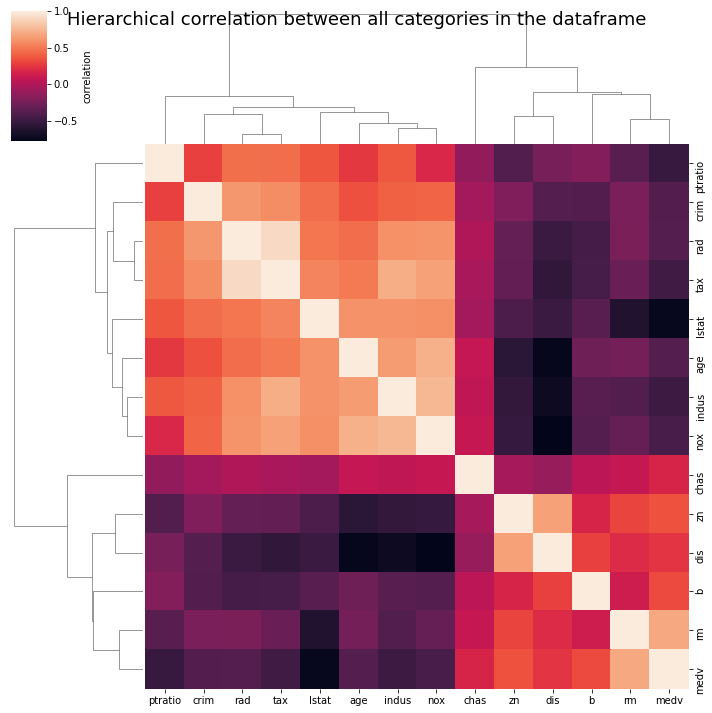

In [5]:
# let's assess multicollinearity
cl_map = sns.clustermap(df.corr(), cbar_kws={'label': 'correlation'})
title = 'Hierarchical correlation between all categories in the dataframe'
cl_map.fig.suptitle(title, fontsize=18)

Text(0.5, 0.98, 'Only high-correlated (>0.5) categories in the dataframe')

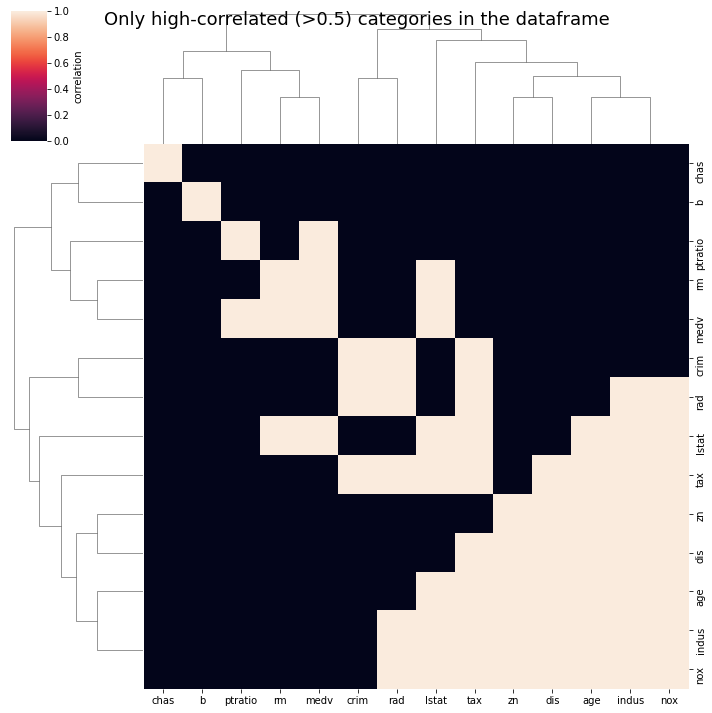

In [6]:
cl_map_corr = sns.clustermap(df.corr().abs() > 0.5, 
                             cbar_kws={'label': 'correlation'})
title_corr = 'Only high-correlated (>0.5) categories in the dataframe'
cl_map_corr.fig.suptitle(title_corr, fontsize=18)

### first attempt: a linear model based on all parameters

In [7]:
# let's extract all our parameters into features
# and our desirable housing price into target
target = df['medv']
features = df.iloc[:, :-1]

In [8]:
# let's have a look for a quality of features
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


In [9]:
# and reassure that all have the same shape
features.shape[0] == target.shape[0]

True

To avoid any preponderances let's standardise our predictors

In [10]:
means = features.mean(axis=0)
stds = features.std(axis=0)

scaled_features = (features - means) / stds

scaled_features.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,-0.419367,0.284548,-1.286636,-0.272329,-0.144075,0.413263,-0.119895,0.140075,-0.981871,-0.665949,-1.457558,0.440616,-1.074499
1,-0.416927,-0.487240,-0.592794,-0.272329,-0.739530,0.194082,0.366803,0.556609,-0.867024,-0.986353,-0.302794,0.440616,-0.491953
2,-0.416929,-0.487240,-0.592794,-0.272329,-0.739530,1.281446,-0.265549,0.556609,-0.867024,-0.986353,-0.302794,0.396035,-1.207532
3,-0.416338,-0.487240,-1.305586,-0.272329,-0.834458,1.015298,-0.809088,1.076671,-0.752178,-1.105022,0.112920,0.415751,-1.360171
4,-0.412074,-0.487240,-1.305586,-0.272329,-0.834458,1.227362,-0.510674,1.076671,-0.752178,-1.105022,0.112920,0.440616,-1.025487


In [11]:
# let's transfer our features into another format
X = sm.add_constant(scaled_features)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [12]:
# first, ordinary least squares modelling
model = sm.OLS(target, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Thu, 15 Dec 2022   Prob (F-statistic):          6.72e-135
Time:                        00:56:05   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.5328      0.211    106.814      0.0

As we can see, R-squared (and the adjusted version) is significantly bigger than 0, therefore, our model can notably predict a house price even without any corrections

In [13]:
# let's make predicitions based on the obtained formula
predictiton_result = results.get_prediction(X)
target_pred = predictiton_result.predicted_mean

## 2: diagnostics

### a) Let's check if our correlation is linear

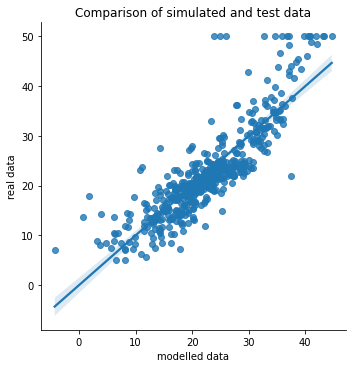

In [14]:
# and compare them with our real housing price data
first_pred = pd.DataFrame({'real': target,
                           'fit': target_pred})
sns.lmplot(x='fit', y='real', data=first_pred)
plt.title('Comparison of simulated and test data')
plt.ylabel('real data')
plt.xlabel('modelled data');

### b) check for influencers

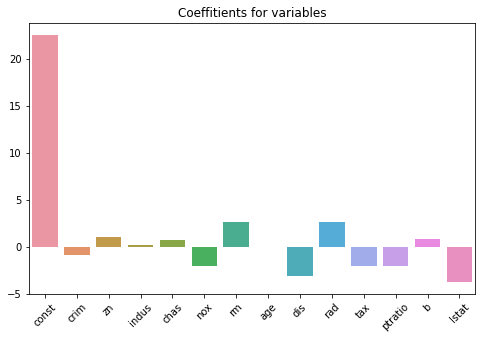

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(x=results.params.index, y=results.params)
plt.xticks(rotation=45)
plt.title('Coeffitients for variables');

### c) multicollinearity

In [16]:
# let's see if we have any outliers
influence = results.get_influence()
cooks = influence.cooks_distance
(cooks[1] < 0.05).sum()

0

In [17]:
# variance inflation factor describes influence by other parameters
vif_data = pd.DataFrame()
vif_data['features'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data.sort_values(by='VIF')

,features,VIF
0,const,1.000000
4,chas,1.073995
12,b,1.348521
1,crim,1.792192
11,ptratio,1.799084
6,rm,1.933744
2,zn,2.298758
13,lstat,2.941491
7,age,3.100826
8,dis,3.955945


In [18]:
# let's wrap it into a function
def calculate_vif(X):
  vif_data = pd.DataFrame()
  vif_data['features'] = X.columns
  vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  return vif_data

In [19]:
# to avoid multicollinearity let's remove the most influenced feature
model_updated = sm.OLS(target, X.drop(columns=['tax']))
results_updated = model_updated.fit()

print(results_updated.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     113.9
Date:                Thu, 15 Dec 2022   Prob (F-statistic):          1.21e-133
Time:                        00:56:08   Log-Likelihood:                -1504.3
No. Observations:                 506   AIC:                             3035.
Df Residuals:                     493   BIC:                             3089.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.5328      0.213    105.772      0.0

In [20]:
# the left ones are twice less influnced than taxes 
# which I would be happy to remove from anywhere
calculate_vif(X.drop(columns=['tax'])).sort_values(by='VIF')

,features,VIF
0,const,1.000000
4,chas,1.058220
11,b,1.347564
10,ptratio,1.788839
1,crim,1.791940
6,rm,1.923075
2,zn,2.184240
9,rad,2.837494
12,lstat,2.940800
7,age,3.098044


In [21]:
# however, age and industry around have a big p-value
# as well as they have a signifficant VIF
# therefore, it's logical to filter them
calculate_vif(X.drop(columns=['tax', 'age', 'indus'])).sort_values(by='VIF')

,features,VIF
0,const,1.000000
3,chas,1.052428
9,b,1.338982
8,ptratio,1.717222
1,crim,1.787963
5,rm,1.806735
2,zn,2.154054
10,lstat,2.579040
7,rad,2.776775
6,dis,3.410587


In [22]:
# let's calculate a model with age and industry filtered out as features
model_filtered = sm.OLS(target, X.drop(columns=['tax', 'age', 'indus']))
results_filtered = model_filtered.fit()

print(results_filtered.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     136.7
Date:                Thu, 15 Dec 2022   Prob (F-statistic):          1.84e-135
Time:                        00:56:08   Log-Likelihood:                -1505.0
No. Observations:                 506   AIC:                             3032.
Df Residuals:                     495   BIC:                             3079.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.5328      0.213    105.828      0.0

As you can see, our model does not loss much of R-squared by dropping age and industry

In [23]:
# let's compare a predicted model and filtered one
preds_full = results.get_prediction(X).predicted_mean
preds_filtered = results_filtered.get_prediction(X.drop(columns=['tax', 'age', 'indus'])).predicted_mean

In [24]:
# calculate a difference
errors_full = target - preds_full
errors_filtered = target - preds_filtered

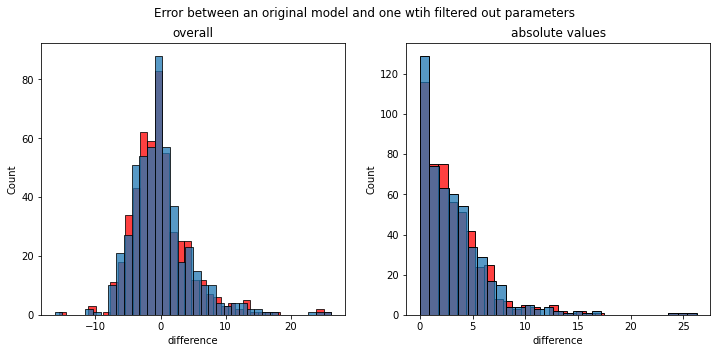

In [25]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
plt.suptitle('Error between an original model and one wtih filtered out parameters')

sns.histplot(errors_full, color='r', ax=ax[0]).set_xlabel('difference')
sns.histplot(errors_filtered, ax=ax[0]).set_title('overall')

sns.histplot(errors_full.abs(), color='r', ax=ax[1]).set_xlabel('difference')
sns.histplot(errors_filtered.abs(), ax=ax[1]).set_title('absolute values');

In [26]:
# let's check if they are signifficantly different
stats.mannwhitneyu(errors_full.abs(), errors_filtered.abs())

MannwhitneyuResult(statistic=127261.0, pvalue=0.8707379018977531)

### d) normality of distribution and constant dispersion

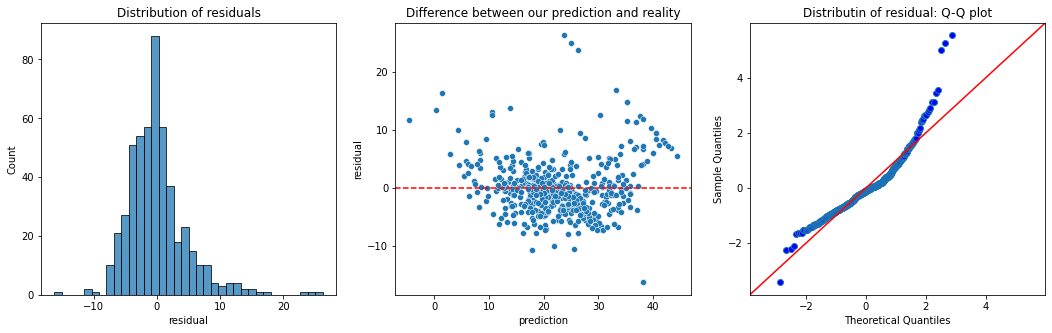

In [27]:
resid_full = target - preds_filtered

fig, ax = plt.subplots(1,3, figsize=(18,5))

sns.histplot(resid_full, ax=ax[0])
ax[0].set_xlabel('residual')
ax[0].set_title('Distribution of residuals');

sns.scatterplot(x=preds_filtered, y=resid_full, ax=ax[1])
ax[1].set_title('Difference between our prediction and reality')
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('residual')
ax[1].axhline(0, c='r', linestyle='--');

sm.qqplot(resid_full, line ='45', fit=True, ax=ax[2], c='tab:blue');
ax[2].set_title('Distributin of residual: Q-Q plot');

In [28]:
# let's see if our residual are distributed normally
stats.shapiro(resid_full)

ShapiroResult(statistic=0.9079424142837524, pvalue=6.029915054940057e-17)

## 3: prediction by the most influencial parameter

Text(24.049999999999997, 0.5, 'lower status of the population')

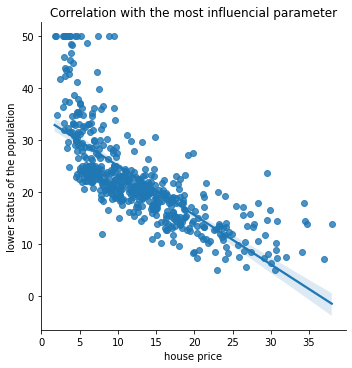

In [29]:
sns.lmplot(x='lstat', y='medv', data=df)
plt.title('Correlation with the most influencial parameter')
plt.xlabel('house price')
plt.ylabel('lower status of the population')

## Additionally

Task: to choose a district to optimise a house price for sale

To estimate a house price for a new-build house, new constructions should be analysed. 
As we have seen, there a selling of price that often mess up with prediction. This direction could researched too.

In [30]:
# let's have a look where we can drow a line for a newbies
df.age.describe()

count    506.000000
mean      68.574901
std       28.148861
min        2.900000
25%       45.025000
50%       77.500000
75%       94.075000
max      100.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'House age distribution: a cut for a new construction')

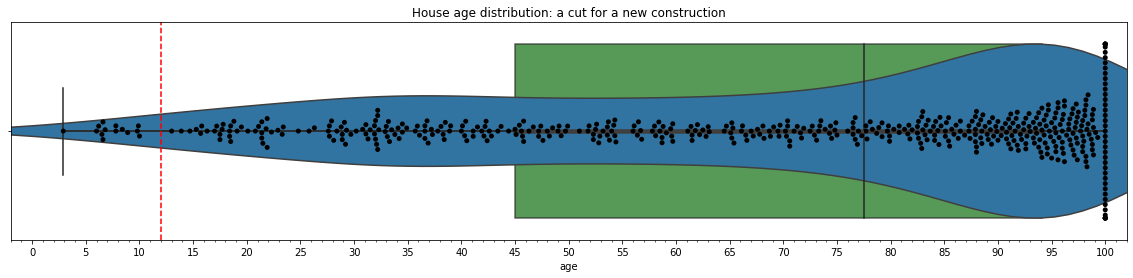

In [31]:
# let's plot it and estimate out cutline
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.figure(figsize=(20,4))
sns.violinplot(data=df, x='age').xaxis.set_minor_locator(MultipleLocator(1))
sns.swarmplot(data=df, x='age', color='k')
sns.boxplot(data=df, x='age', boxprops=dict(alpha=.7), color='g')
plt.xticks(range(0,int(df.age.max()) + 1,5));
plt.xlim(left=-2, right=int(df.age.max()) +2);
plt.axvline(12, c='r', linestyle='--')
plt.title('House age distribution: a cut for a new construction')

In [32]:
# since there are not so much new comers on house market
# we have to cut quite old houses
df_newbies = df[df.age < 12]
df_newbies.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,14.000000,14.000000,14.000000,14.0,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,0.145885,16.142857,7.447143,0.0,0.430786,6.532143,7.442857,6.225471,4.500000,300.142857,18.064286,382.758571,7.130000,26.842857
std,0.094746,23.540006,3.223193,0.0,0.023384,0.647411,1.929812,1.598873,1.786703,48.803936,1.433987,12.652158,6.592859,5.252650
min,0.021870,0.000000,2.240000,0.0,0.400000,5.412000,2.900000,3.587500,1.000000,233.000000,14.800000,348.930000,3.530000,22.800000
25%,0.083723,0.000000,5.860000,0.0,0.413000,6.219500,6.525000,5.287300,3.250000,268.000000,17.900000,377.095000,4.765000,23.800000
50%,0.127505,0.000000,6.910000,0.0,0.431000,6.405000,7.300000,5.720900,4.000000,305.000000,18.650000,384.570000,5.355000,24.750000
75%,0.186383,22.000000,10.755000,0.0,0.445250,6.792500,8.775000,7.306400,5.750000,330.000000,19.100000,392.755000,6.765000,28.400000
max,0.368940,70.000000,12.830000,0.0,0.489000,8.259000,10.000000,8.906700,7.000000,398.000000,19.200000,396.900000,29.550000,42.800000


In [33]:
# as we can see, all values for chas are zeros we can drop them
# chas is for Charles River dummy variable 
# (= 1 if tract bounds river; 0 otherwise)
df_newbies = df_newbies.drop(columns='chas')

Text(0.5, 1.0, 'All sorts of correlations among parameters for young houses')

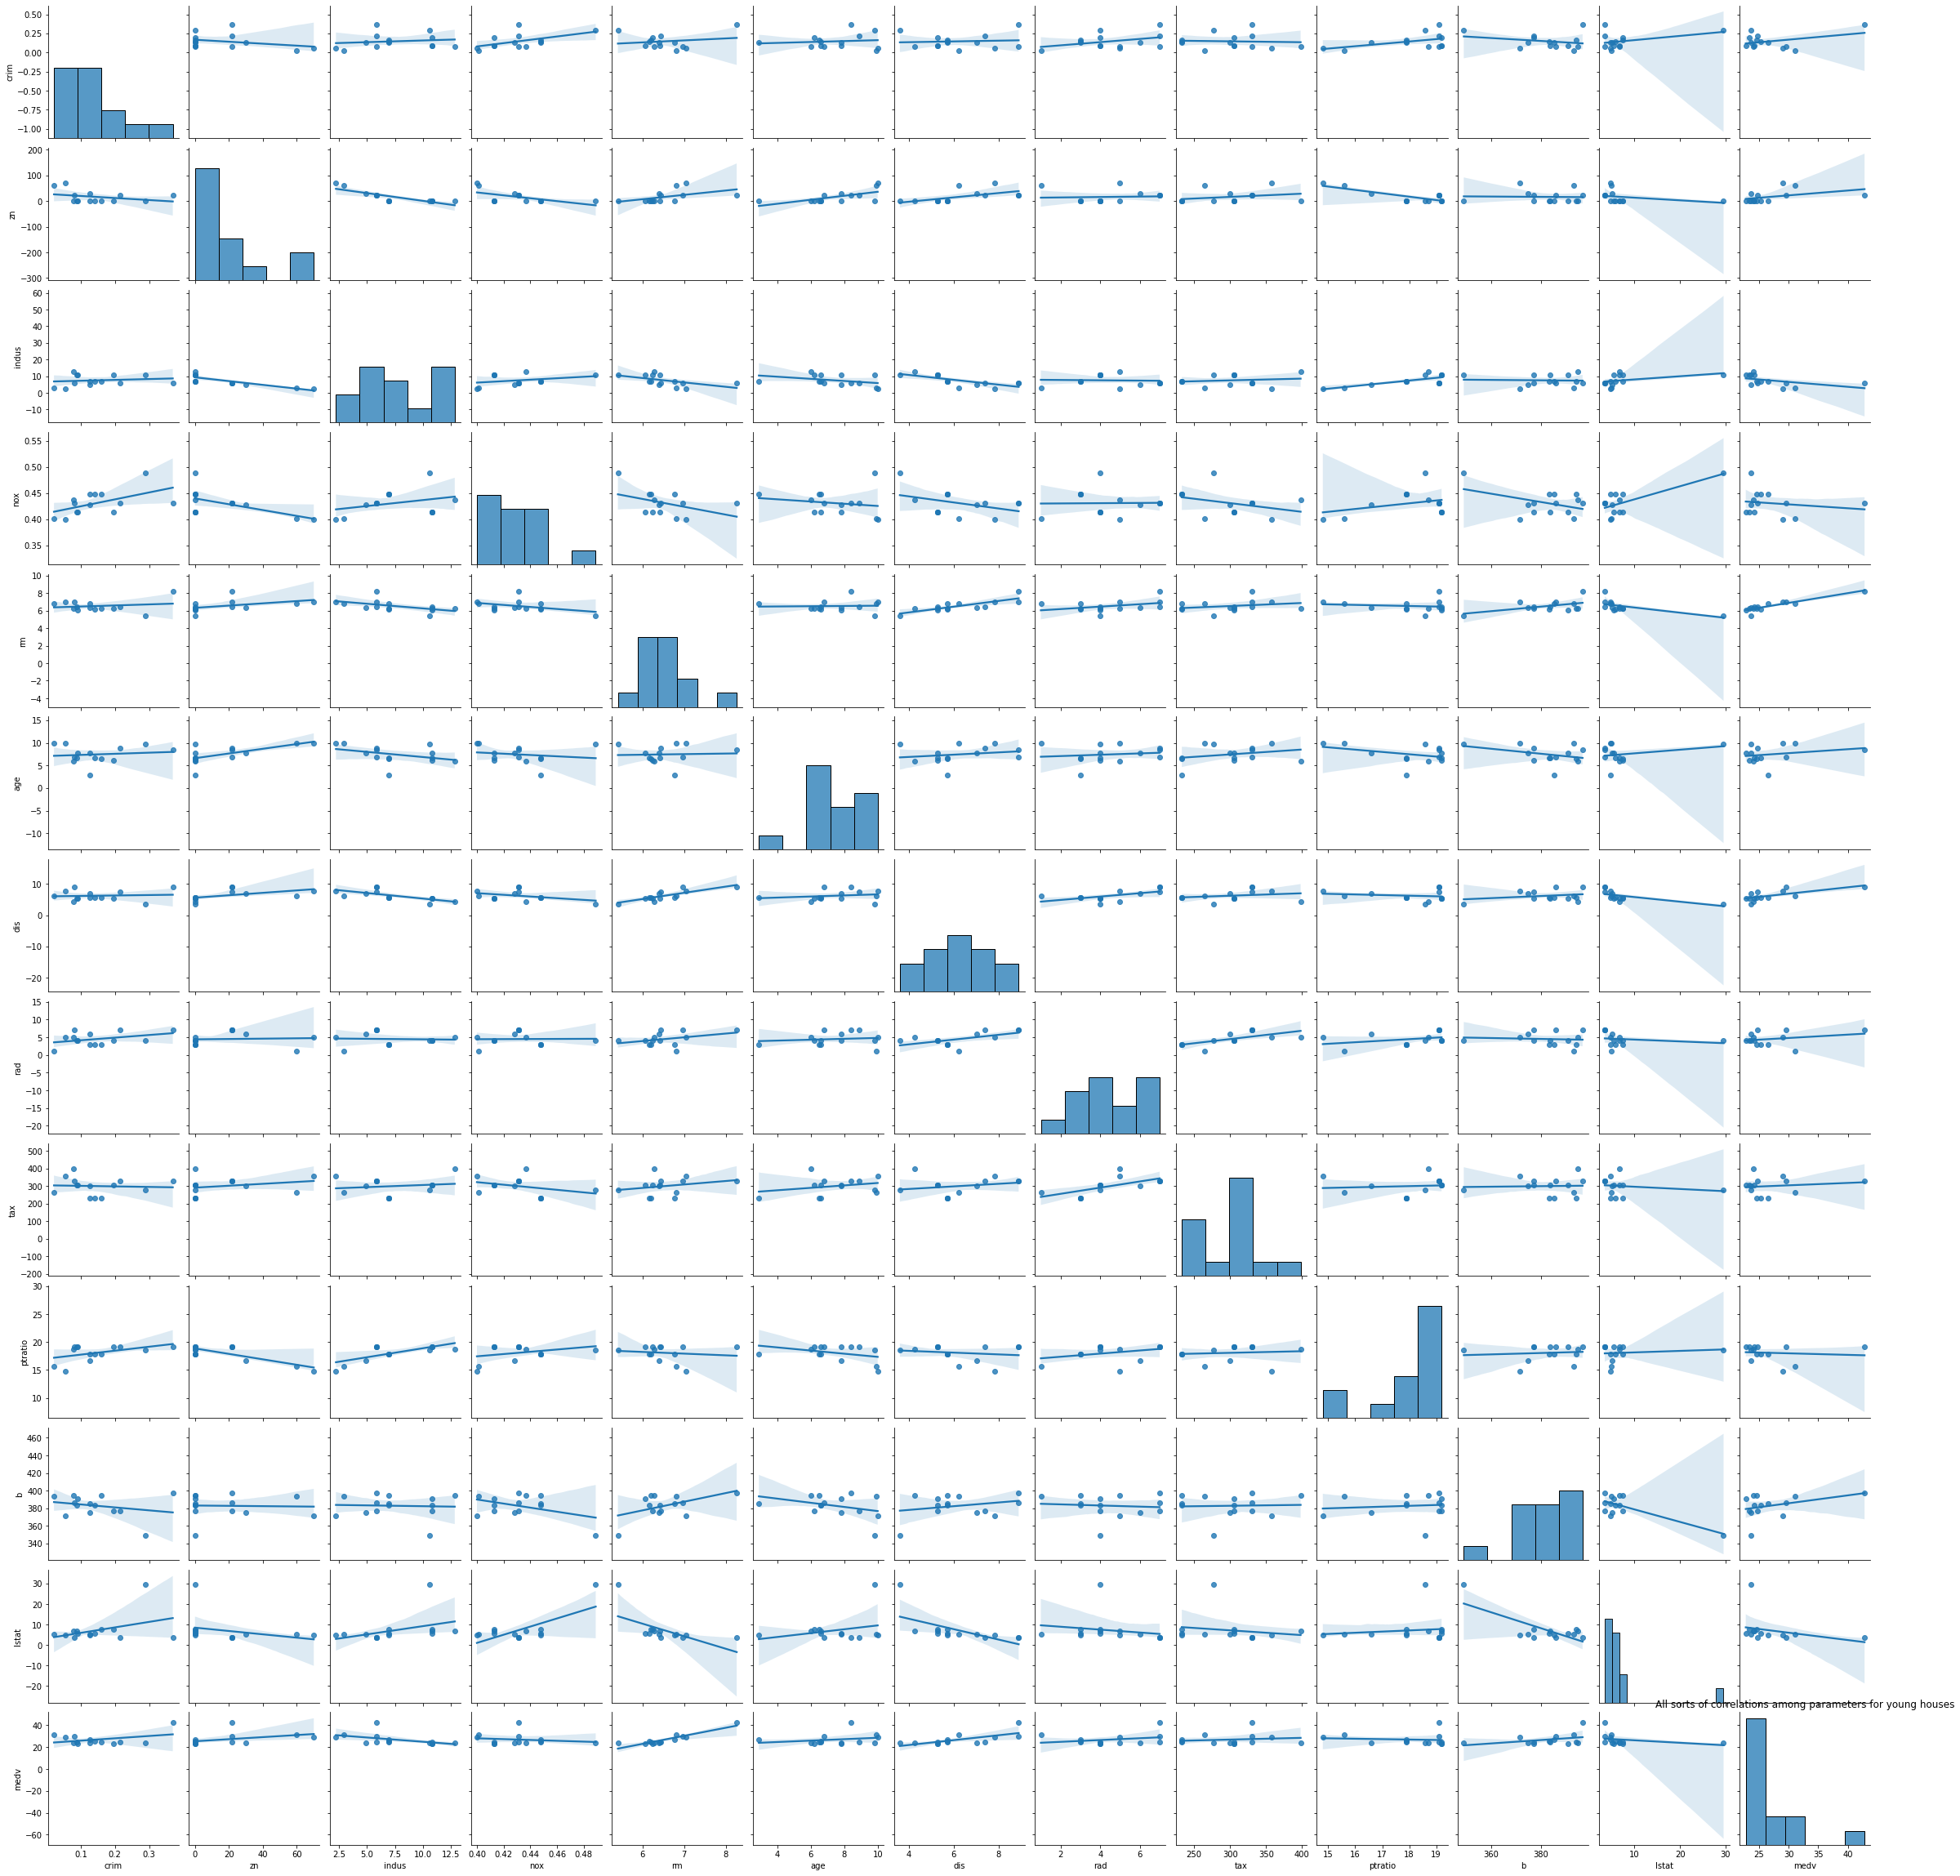

In [34]:
sns.pairplot(data=df_newbies, kind='reg')
plt.title('All sorts of correlations among parameters for young houses')

Text(0.5, 1.0, 'Correlation among all categories in the young dataframe')

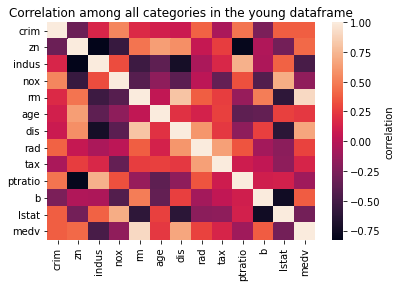

In [35]:
# let's assess multicollinearity
cl_map_newbies = sns.heatmap(data=df_newbies.corr(), 
                             cbar_kws={'label': 'correlation'})
title_newbies = 'Correlation among all categories in the young dataframe'
plt.title(title_newbies)

Text(0.5, 0.98, 'Only high-correlated (>0.5) categories in the young dataframe')

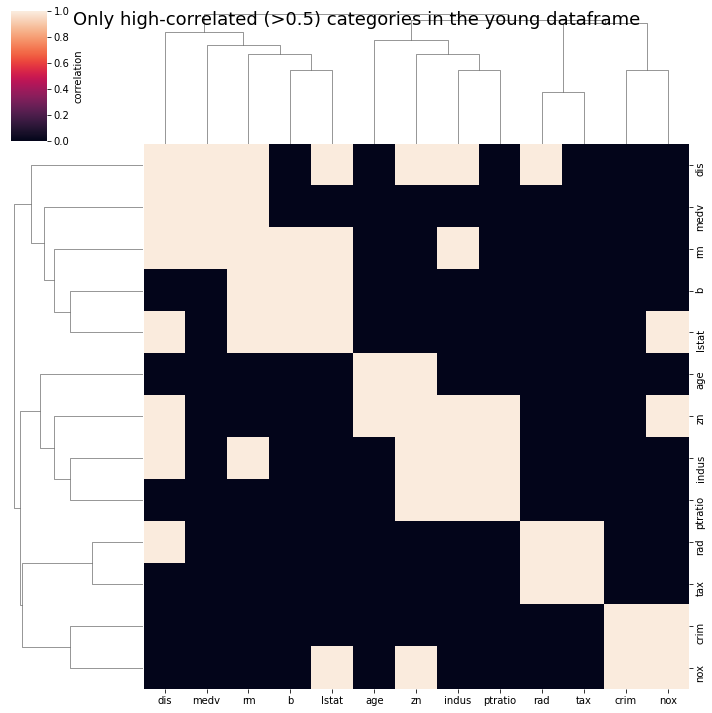

In [36]:
# let's extract high-impact parameters
cl_map_corr_newbies = sns.clustermap(df_newbies.corr().abs() > 0.5, 
                                     cbar_kws={'label': 'correlation'})
title_corr_newbies = 'Only high-correlated (>0.5) categories in the young dataframe'
cl_map_corr_newbies.fig.suptitle(title_corr_newbies, fontsize=18)

In [37]:
# let's extract all our parameters into features
# and our desirable housing price into target
target_newbies = df_newbies['medv']
features_newbies = df_newbies.iloc[:, :-1]

In [38]:
# standartisation to avoid order variations
means_newbies = features_newbies.mean(axis=0)
stds_newbies = features_newbies.std(axis=0)

scaled_features_newbies = (features_newbies - means_newbies) / stds_newbies

scaled_features_newbies.head()

,crim,zn,indus,nox,rm,age,dis,rad,tax,ptratio,b,lstat
41,-0.194679,-0.685763,-0.166649,0.736167,0.367397,-2.354041,-0.315580,-0.839535,-1.375767,-0.114566,0.209563,-0.347346
42,-0.046282,-0.685763,-0.166649,0.736167,-0.560915,-0.436756,-0.315580,-0.839535,-1.375767,-0.114566,0.048326,-0.200217
43,0.142223,-0.685763,-0.166649,0.736167,-0.496042,-0.488575,-0.315580,-0.839535,-1.375767,-0.114566,0.924856,0.047021
70,-0.608206,-0.685763,1.043331,-0.760604,-0.177851,-0.436756,-0.586771,-0.279845,0.099524,0.791998,0.076780,-0.062189
72,-0.572531,-0.685763,1.043331,-0.760604,-0.721555,0.185066,-0.586771,-0.279845,0.099524,0.791998,0.644272,-0.244204


In [39]:
# extract features into a more workable class
X_newbies = sm.add_constant(scaled_features_newbies)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [40]:
# calculate a model
model_newbies = sm.OLS(target_newbies, X_newbies)
results_newbies = model_newbies.fit()

print(results_newbies.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     527.3
Date:                Thu, 15 Dec 2022   Prob (F-statistic):             0.0340
Time:                        00:57:49   Log-Likelihood:                 18.701
No. Observations:                  14   AIC:                            -11.40
Df Residuals:                       1   BIC:                            -3.094
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.8429      0.064    421.876      0.0

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [41]:
# let's make predicitions based on the obtained formula
predictiton_result_newbies = results_newbies.get_prediction(X_newbies)
target_pred_newbies = predictiton_result_newbies.predicted_mean

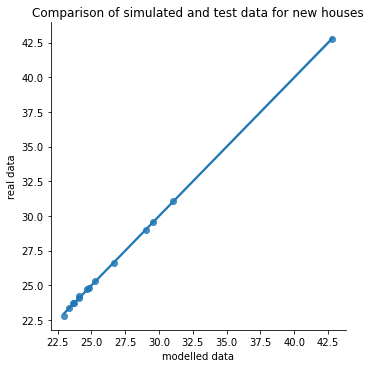

In [42]:
first_pred_newbies = pd.DataFrame({'real': target_newbies,
                                   'fit': target_pred_newbies})
sns.lmplot(x='fit', y='real', data=first_pred_newbies)
plt.title('Comparison of simulated and test data for new houses')
plt.ylabel('real data')
plt.xlabel('modelled data');

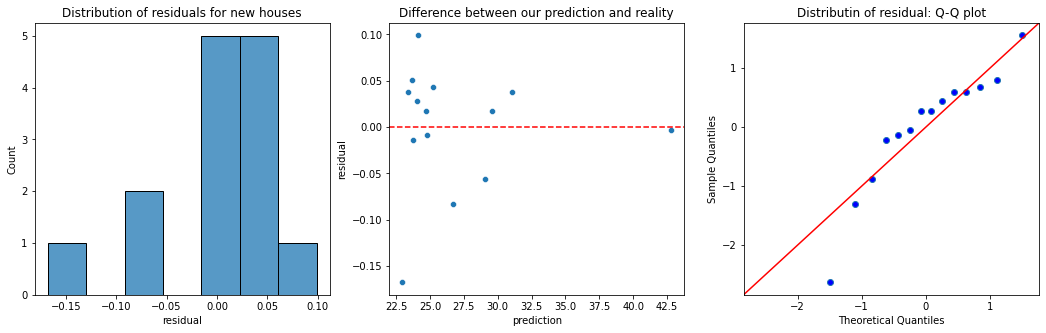

In [43]:
# however, it is too good to be true
# let's assess residuals
preds_newbies = results_newbies.get_prediction(X_newbies).predicted_mean
resid_full_newbies = target_newbies - preds_newbies

fig, ax = plt.subplots(1,3, figsize=(18,5))

sns.histplot(resid_full_newbies, ax=ax[0])
ax[0].set_xlabel('residual')
ax[0].set_title('Distribution of residuals for new houses');

sns.scatterplot(x=preds_newbies, y=resid_full_newbies, ax=ax[1])
ax[1].set_title('Difference between our prediction and reality')
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('residual')
ax[1].axhline(0, c='r', linestyle='--');

sm.qqplot(resid_full_newbies, line ='45', fit=True, 
          ax=ax[2], c='tab:blue');
ax[2].set_title('Distributin of residual: Q-Q plot');

In [44]:
# proof that normalit is not normal
stats.shapiro(resid_full_newbies)

ShapiroResult(statistic=0.8981232643127441, pvalue=0.10593153536319733)

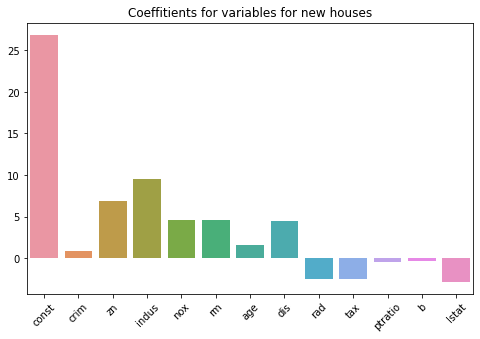

In [45]:
plt.figure(figsize=(8,5))
sns.barplot(x=results_newbies.params.index, 
            y=results_newbies.params)
plt.xticks(rotation=45)
plt.title('Coeffitients for variables for new houses');

In [46]:
# let's see if we have any outliers
influence_newbies = results_newbies.get_influence()
cooks_newbies = influence_newbies.cooks_distance
(cooks_newbies[1] < 0.05).sum()

1

In [47]:
# which one is outlayer
np.array(['const'] + list(df_newbies.columns))[cooks_newbies[1] < 0.05]

array(['lstat'], dtype='<U7')

In [48]:
calculate_vif(X_newbies)

,features,VIF
0,const,1.000000
1,crim,12.260697
2,zn,342.283455
3,indus,470.337104
4,nox,60.465794
5,rm,24.610546
6,age,11.378654
7,dis,91.616260
8,rad,37.875509
9,tax,77.021898


**Conclusion:**
* nonetheless, the adjusted R-squared is almost 1 and all dotes are getting along the prediction
* there is not enough data to build a strong model (residuals are not normally distributed)
* however, it could be hypothesised to build as: 
1.   To do: a) with a high proportion of industrial businesses around, b) a significant proportion of largely residential land zones, c) desirably with enough amount of rooms per dwelling;
2.   Not to do: d) around from radial highways, e) heavily taxed, f) around ghettos;
3.  Other parameters are not significant enough or not represented in this data frame.